# `003` Backpropagation

Requirements: 001 Derivatives.

Backpropagation is the process of calculating the gradients of a function with respect to its parameters, a.k.a. finding their partial derivatives. This basically tells us how much each parameter affects the final result. This is the key to train neural networks, as we need to know how much each weight affects the final result in order to adjust them properly.

Let's consider the following equation:

$$f(x, y, z, w) = x * (y + z * w)$$

And let's say the initial values for $(x, y, z, w)$ are $(2,3,-1,7)$. We could use graphviz to paint the formula like this:

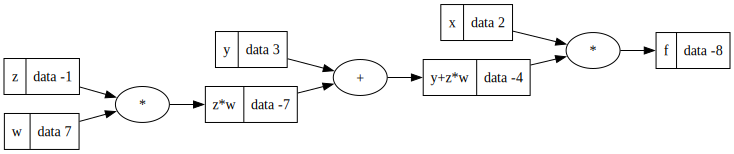

In [1]:
from graphviz import Digraph

d = Digraph(graph_attr={'rankdir': 'LR'})
d.node('x', '{x | data 2}', shape='record')
d.node('y', '{y | data 3}', shape='record')
d.node('z', '{z | data -1}', shape='record')
d.node('w', '{w | data 7}', shape='record')
d.node('z*w', '{z*w | data -7}', shape='record')
d.node('y+z*w', '{y+z*w | data -4}', shape='record')
d.node('f', '{f | data -8}', shape='record')
d.node('+', '+')
d.node('*1', '*')
d.node('*2', '*')
d.edges([('z', '*1'), ('w', '*1'), ('*1', 'z*w'), ('y', '+'), ('z*w', '+'), ('+', 'y+z*w'), ('x', '*2'), ('y+z*w', '*2'), ('*2', 'f')])
d

Now, we need to know how each individual node in that tree contributes to the final value of f, and we do this from the final node backwards, which is why it is called backpropagation.

Going node by node:
* For the final node $f$, the gradient is always 1. This is because the final value is the final value, and increasing it by 1 will increase the final value by 1.
* Then, we have a `*` node, which multiplies the values of $x$ and $(y + z * w)$. If we increase $x$ by 1, the final value will increase by $(y + z * w)$, which is -4. If we increase $(y + z * w)$ by 1, the final value will increase by $x$, which is 2. Hence, the gradient for $x$ is $(y + z * w)$, and the gradient for $(y + z * w)$ is $x$. We can see the multiplication node as a gradient-swapper.
* Then, we have a `+` node, which adds the values of $y$ and $(z * w)$. If we increase any of the two terms of $y + (z * w)$ by 1, the value of such equation will increase by 1. And since the gradient of that equation is $2$, we have to multiply the gradient of the `+` node by 2. Hence, the gradient for $y$ is 2, and the gradient for $(z * w)$ is 2. We can see the addition node as a gradient-distributor.
* Finally, we have another `*` node, which multiplies the values of $z$ and $w$. We know that `*` is a gradient-swapper, so the gradient for $z$ is $w$, and the gradient for $w$ is $z$. But again, due to the chain rule, we have to multiply those gradients by the parent gradient, which is 2. Hence, the gradient for $z$ is $2w=14$, and the gradient for $w$ is $2z=-2$.

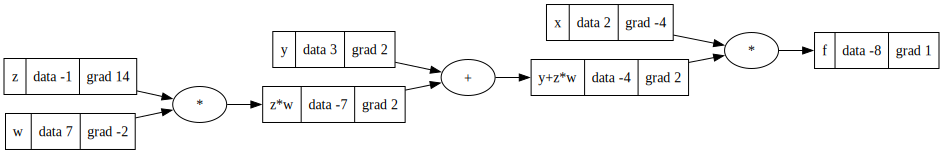

In [2]:
from graphviz import Digraph

d = Digraph(graph_attr={'rankdir': 'LR'})
d.node('x', '{x | data 2 | grad -4}', shape='record')
d.node('y', '{y | data 3 | grad 2}', shape='record')
d.node('z', '{z | data -1 | grad 14}', shape='record')
d.node('w', '{w | data 7 | grad -2}', shape='record')
d.node('z*w', '{z*w | data -7 | grad 2}', shape='record')
d.node('y+z*w', '{y+z*w | data -4 | grad 2}', shape='record')
d.node('f', '{f | data -8 | grad 1}', shape='record')
d.node('+', '+')
d.node('*1', '*')
d.node('*2', '*')
d.edges([('z', '*1'), ('w', '*1'), ('*1', 'z*w'), ('y', '+'), ('z*w', '+'), ('+', 'y+z*w'), ('x', '*2'), ('y+z*w', '*2'), ('*2', 'f')])
d

What we just did is called backpropagation. And thanks to the chain rule, we can compute the gradients of any given function as long as we are able to model the local derivatives of each operator.